In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pyodbc
import re

In [4]:
sql_conn = pyodbc.connect('DRIVER={SQL Server};'
                            'SERVER=L_AAGDATIX;'
                            'DATABASE=DatixCRM;'
                            'Trusted_Connection=yes') 
query = "set transaction isolation level read uncommitted select c.description,b.con_email,a.inc_dincident,a.inc_time from contacts_main b join incidents_main a on a.recordid=b.recordid join code_con_type c on b.con_type=c.code where a.inc_type='PAT' and a.inc_category='MEDIC' and a.inc_organisation='QA' and a.show_employee='Y'"
df = pd.read_sql(query, sql_conn)
#df = df.dropna()
df_columns = list(df.columns)
df_columns[0] = 'employee_involved'
df.columns = df_columns
df['con_email'] = df['con_email'].str.split("@",n=1,expand=True)[0]
df

,employee_involved,con_email,inc_dincident,inc_time
0,Employee (General),philippa.cheesman,2016-03-31,2100
1,Employee (General),jasmin.hall,2016-03-25,1400
2,Employee (General),fred.flintstone,2016-04-01,1800
3,Employee (General),kljkljkljkljkl,2016-04-02,1600
4,Employee (General),None,2016-04-02,1700
5,Patient,None,2016-04-03,1715
6,Employee (General),violeta.sinense,2016-04-02,1000
7,Employee (Registered Allied Health Professional),None,2016-04-02,1000
8,Patient,None,2016-04-02,1000
9,Employee (Registered Nurse / Midwife),helen.redding,2016-04-02,1200


In [3]:
df = df[df['employee_involved'].str.contains('Employee')]
df['employee_involved'] = df['employee_involved'].str.strip('Employee (')
df['employee_involved'] = df['employee_involved'].str.strip('Registered ')
df['employee_involved'] = df['employee_involved'].str.strip('\)')
df['employee_involved'] = df['employee_involved'].str.replace('administrative','administrative)')
df['employee_involved'] = df['employee_involved'].str.replace(' / ','/')
df['employee_involved'] = df['employee_involved'].str.replace(' and ',' & ')
df['employee_involved'] = df['employee_involved'].str.replace(' staff','')
print(df)

                       employee_involved               con_email  \
0                                General       philippa.cheesman   
1                                General             jasmin.hall   
2                                General         fred.flintstone   
3                                General          kljkljkljkljkl   
4                                General                    None   
6                                General         violeta.sinense   
7             Allied Health Professional                    None   
9                          Nurse/Midwife           helen.redding   
10                               General                    None   
11                               General         abigail.mahoney   
13                         Nurse/Midwife             anne.taylor   
14                         Nurse/Midwife           lara.mouraesa   
15                         Nurse/Midwife           janyne.frazer   
16                         Nurse/Midwife        

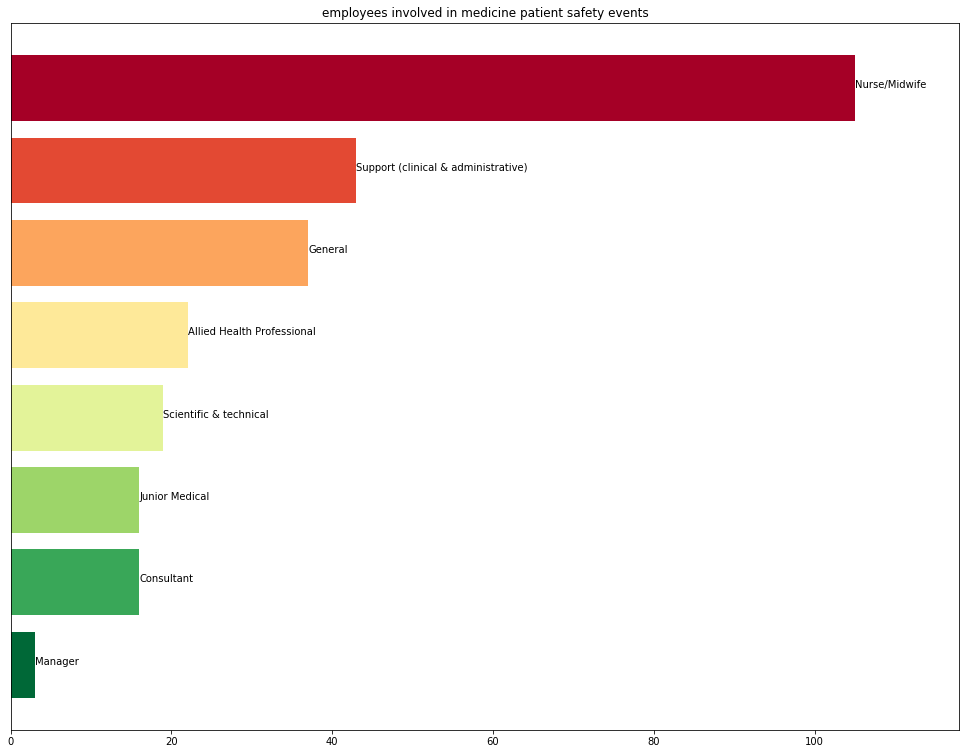

In [4]:
reportedby_counts = df['employee_involved'].value_counts()
plt.figure(figsize=(17,13))
cm = plt.get_cmap('RdYlGn')
cm_subsection = np.linspace(0, 1, len(reportedby_counts.values))
x_range = range(0,len(reportedby_counts.values))
colors = [cm(x) for x in cm_subsection]
reportedby_list = list(reportedby_counts.index)
for i in x_range:
    plt.barh(reportedby_list[-(i+1)],reportedby_counts.values[-(i+1)],color=colors[-(i+1)])
    plt.text(reportedby_counts.values[-(i+1)],i,reportedby_list[-(i+1)])
plt.yticks([])
plt.xlim([0,max(reportedby_counts)+len(reportedby_list[0])])
plt.title("employees involved in medicine patient safety events");

In [5]:
email_counts = df['con_email'].value_counts(ascending=True)
print(email_counts)

louise.bolton             1
violeta.sinense           1
ann.dowd                  1
louise.bailey2            1
vanessa.oliveirapicao     1
kelly.wootton             1
Georgina.Veater           1
anthony.wise              1
janet.gowan               1
alison.morgan             1
jon.davey                 1
simon.veal                1
louise.taylor             1
lara.mouraesa             1
jana.bujanova             1
michelle.stables          1
lucy.burgess              1
jackie.davis              1
beverley.moxon            1
sara.wye                  1
aneeta.sinha              1
melcor.fajardo            1
pema.jigme                1
tracy.white2              1
trudie.pestell            1
jasmin.fuller             1
Alicia.Villarin-Rivas     1
hayley.nelson             1
chinnu.aby                1
sophie.hepworth           1
                         ..
jane.lyndon               1
mary.busby                1
charlotte.chivers         1
anne.taylor               1
carol.jones         

In [6]:
df['hour'] = df['inc_time'].str[:2]
df = df.astype({'hour':'int'})
df.head()

,employee_involved,con_email,inc_dincident,inc_time,hour
0,General,philippa.cheesman,2016-03-31,2100,21
1,General,jasmin.hall,2016-03-25,1400,14
2,General,fred.flintstone,2016-04-01,1800,18
3,General,kljkljkljkljkl,2016-04-02,1600,16
4,General,None,2016-04-02,1700,17


In [7]:
total_days = (max(df.inc_dincident)-min(df.inc_dincident)).days
print(total_days)

1341


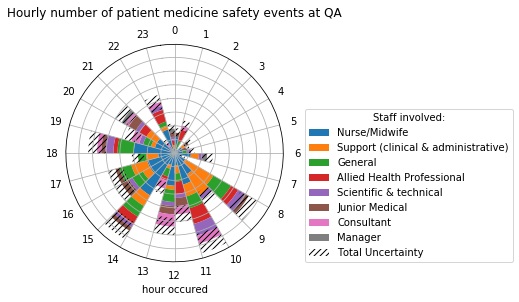

In [8]:
bins = [i-0.5 for i in range(25)]
data_x = [i for i in range(24)]
data_y_tot,_ = np.histogram(df.hour, bins=bins)

# Compute pie slices
N = 24
width = 2 * np.pi/N
theta = np.linspace(0.0 + width, 2 * np.pi + width, N, endpoint=False)
theta_deg = np.linspace(0.0 + 7.5, 360 + 7.5, N, endpoint=False)
radii = data_y_tot/total_days
radii_err = np.sqrt(data_y_tot)/total_days

staff_counts = df['employee_involved'].value_counts()

ax = plt.subplot(111, projection='polar')
cumulative_bottom = 0
for i,counts in staff_counts.items():
    radii_staff_tot,_ = np.histogram(df[df['employee_involved']==i].hour, bins=bins)
    radii_staff = radii_staff_tot/total_days
    ax.bar(theta, radii_staff, bottom=cumulative_bottom, width=width, label=i);
    cumulative_bottom += radii_staff

ax.bar(theta, radii_err, bottom=cumulative_bottom-radii_err/2,width=width,alpha=0.5,color='none',hatch="////",label='Total Uncertainty');
ax.set_theta_offset(np.pi/2 + width/2)
ax.set_theta_direction(-1)
ax.set_yticklabels([])
plt.xlabel('hour occured')
plt.title('Hourly number of patient medicine safety events at QA',y=1.1)
plt.legend(loc=(1.1,0),title='Staff involved:')
lines, labels = plt.thetagrids( theta_deg, (data_x) )

In [9]:
df['weekday'] = df['inc_dincident'].dt.weekday
total_weeks = (max(df.inc_dincident)-min(df.inc_dincident)).days/7
print(total_weeks)

191.57142857142858


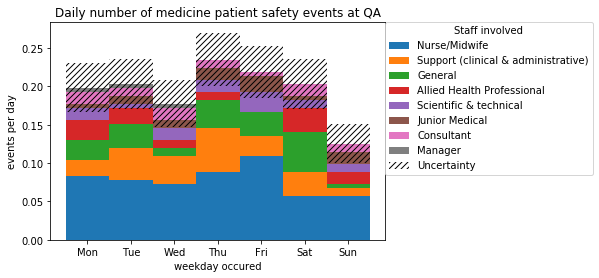

In [44]:
bins = [i-0.5 for i in range(8)]
data_x = [i for i in range(7)]
data_y_tot,_ = np.histogram(df.weekday.values, bins=bins)
data_y = data_y_tot/total_weeks
data_y_err = np.sqrt(data_y_tot)/total_weeks
per_role_weekday = []
per_role_label = []
per_role_weight = []
for i,counts in staff_counts.items():
    per_role_weekday.append(df[df['employee_involved']==i].weekday.values)
    per_role_label.append(i)
    per_role_weight.append(np.ones(len(df[df['employee_involved']==i].weekday.values))/total_weeks)
plt.hist(weekday_per_role,bins=bins,weights=weights_per_role,stacked=True,label=per_role_label)
plt.bar(data_x,2*data_y_err,bottom=data_y-data_y_err,color='none',alpha=0.5,hatch="////",label='Uncertainty',width=1)
plt.ylim(bottom=0)
ax = plt.gca()
locs, labels = plt.xticks()
plt.xticks(np.arange(7),labels=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
plt.xlabel('weekday occured');
plt.ylabel('events per day')
plt.legend(title='Staff involved',loc=(1,0.3))
plt.title('Daily number of medicine patient safety events at QA');